# Atmospheric Carbon Dioxide

The general purpose of this exercise is to forecast future atmopsheric carbon dioxide concentration by fitting a model to observations collected by the U.S. National Oceanic and Atmospheric Administration (NOAA) from 1958 to 2018 at the Mauna Loa Observatory in Hawaii.


In [368]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [369]:
# Load data
df = pd.read_csv('../datasets/mauna_loa_co2.csv')


In [370]:
# Explore top rows
df.head(5)


,year,month,co2_ppm
0,1958,3,315.71
1,1958,4,317.45
2,1958,5,317.50
3,1958,6,317.10
4,1958,7,315.86


In [371]:
# Explore bottom rows
df.tail(5)


,year,month,co2_ppm
724,2018,7,408.71
725,2018,8,406.99
726,2018,9,405.51
727,2018,10,406.00
728,2018,11,408.02


In [372]:
# Create dates in datetime format (just in case)
df["day"] = np.ones(df["year"].shape)*15
df["dates"] = pd.to_datetime(df[['year', 'month', 'day']])
df.head()

,year,month,co2_ppm,day,dates
0,1958,3,315.71,15.0,1958-03-15
1,1958,4,317.45,15.0,1958-04-15
2,1958,5,317.50,15.0,1958-05-15
3,1958,6,317.10,15.0,1958-06-15
4,1958,7,315.86,15.0,1958-07-15


In [373]:
# Solution using serial number
# Optimization routine gives slighly different paramater values
df["serial_date"] = df['year'] + df['month']/12
df.head()


,year,month,co2_ppm,day,dates,serial_date
0,1958,3,315.71,15.0,1958-03-15,1958.250000
1,1958,4,317.45,15.0,1958-04-15,1958.333333
2,1958,5,317.50,15.0,1958-05-15,1958.416667
3,1958,6,317.10,15.0,1958-06-15,1958.500000
4,1958,7,315.86,15.0,1958-07-15,1958.583333


In [374]:
# Establash x and y data for the curve fitting routine
x_obs = df["serial_date"] - df["serial_date"][0]
y_obs = df['co2_ppm']


## Explore data

In [375]:
idx_2010s = df["year"] >= 2010
df_2010s = df[idx_2010s]

idx_1960s = df["year"] <= 1960
df_1960s = df[idx_1960s] # or df.loc[idx_2000s, :]


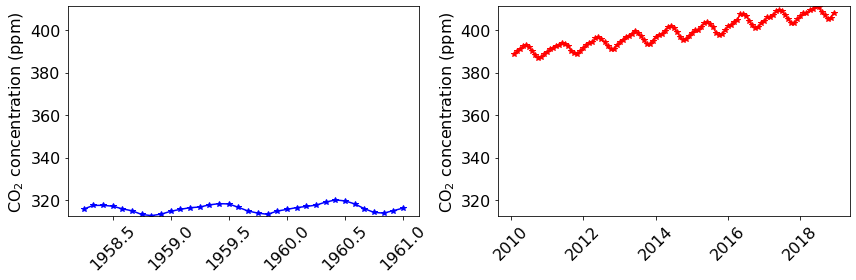

In [376]:
historical_min = df["co2_ppm"].min()
historical_max = df["co2_ppm"].max()

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(df_1960s["serial_date"], df_1960s["co2_ppm"], '*-b')
plt.ylabel("CO$_2$ concentration (ppm)", size=16)
plt.ylim(historical_min, historical_max)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(df_2010s["serial_date"], df_2010s["co2_ppm"], '*-r')
plt.ylabel("CO$_2$ concentration (ppm)", size=16)
plt.ylim(historical_min, historical_max)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=45)


plt.tight_layout()
plt.show()

## Exponential model

We will fit the following simplified model to the carbon dioxide time series and by optmizing the model parameters:

$$y(t) = a + b \ exp \bigg(\frac{c \ t}{d}\bigg)$$


$t$ is time since March, 1958 (the start of the data set)

$a$, $b$, $c$, and $d$ are unknown parameters.

In [377]:
# Define lambda function
model = lambda t,a,b,c,d: a + b*np.exp(c*t/d)


In [378]:
# Curve fitting
par = curve_fit(model, x_obs, y_obs)

# Display parameters
print('a:',par[0][0])
print('b:',par[0][1])
print('c:',par[0][2])
print('d:',par[0][3])


a: 256.7255721449055
b: 56.94985927360677
c: 0.010138696100797776
d: 0.6239442187866756


In [379]:
# Predict CO2 using model
y_pred = model(x_obs, *par[0])


Using the model and the optimized parameters we can predict the carbon dioxide concentration for the observation years and calculate the error of the model using the mean absolute error (MAE).


In [380]:
# Compute MAE
maefn = lambda obs,pred: np.mean(np.abs(obs - pred))

mae = maefn(y_obs, y_pred)
print('MAE is:',np.round(mae,2), 'ppm')


MAE is: 1.88 ppm


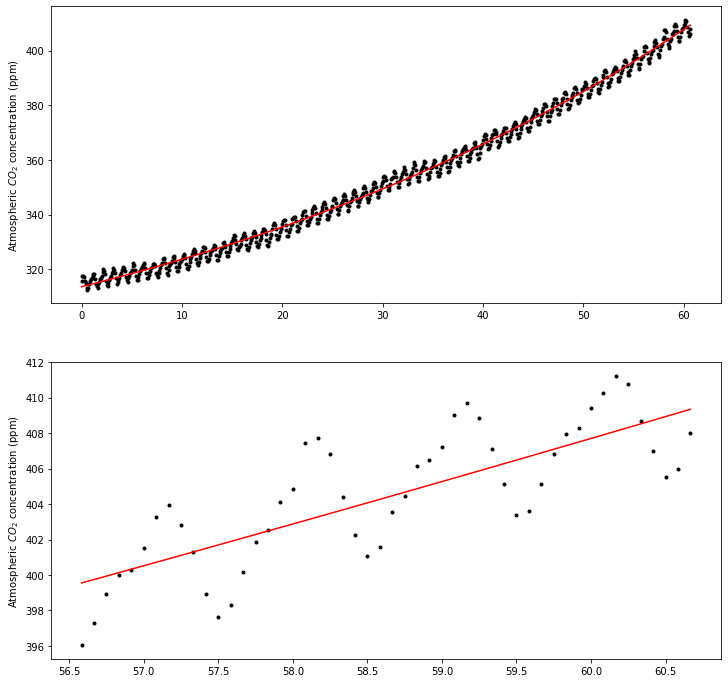

In [381]:
# Plot observations and predictions
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.plot(x_obs, y_obs, '.k')
plt.plot(x_obs, y_pred, '-r')
plt.ylabel('Atmospheric $CO_2$ concentration (ppm)')

plt.subplot(2,1,2)
subset = np.arange( df.shape[0]-50, df.shape[0])
plt.plot(x_obs[subset], y_obs[subset], '.k')
plt.plot(x_obs[subset], y_pred[subset], '-r')
plt.ylabel('Atmospheric $CO_2$ concentration (ppm)')

plt.show()

### Examine residuals

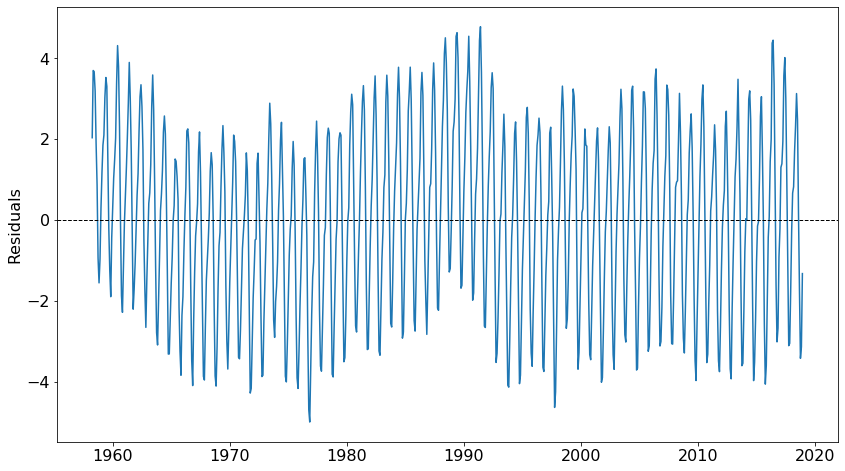

In [382]:
# Calculate residuals
residuals = y_obs - y_pred

plt.figure(figsize=(14,8))
plt.plot(df['serial_date'], residuals)
plt.axhline(y=residuals.mean(), linewidth=1, color='k', linestyle='--')
plt.ylabel('Residuals', size=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()


In [383]:
# Check if residuals approach a zero mean
print(residuals.mean()) 

# Estimate amplitude of potential sine wave model
avg_min_val = residuals.groupby(df["year"]).min().mean()
avg_max_val = residuals.groupby(df["year"]).max().mean()
amplitude = (avg_max_val-avg_min_val)/2
print(amplitude)


1.8889463399505767e-06
3.1807161530764363


Residuals exhibit a mean close to zero and a sinusoidal pattern. This suggests that a model involving sine or cosine oscillations could be used to added to the current model to improve predictions.

### Forecast concentration in year 2050

In [358]:
co2_2050 = model(2050-df['serial_date'][0], *par[0])
print('Carbon dioxide concentration in 2050 is estimated to be:', np.round(co2_2050),'ppm')


Carbon dioxide concentration in 2050 is estimated to be: 510.0 ppm


### Project data in chart

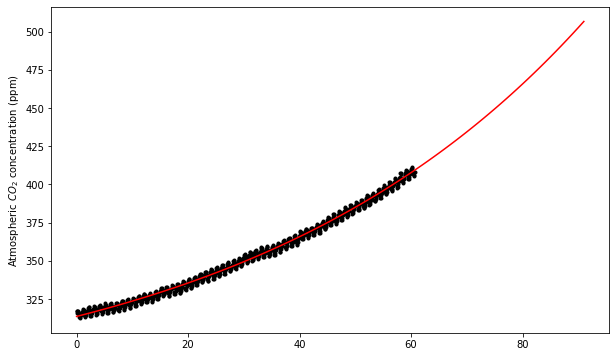

In [359]:
x_forecast = range(df["year"][0],2050) - df["year"][0]
y_forecast = model(x_forecast, *par[0])

plt.figure(figsize=(10,6))
plt.plot(x_obs, y_obs, '.k')
plt.plot(x_forecast, y_forecast, '-r')
plt.ylabel('Atmospheric $CO_2$ concentration (ppm)')
plt.show()


## Sinusoidal-exponential model

$$y(t) = a + b \ exp \bigg(\frac{c \ t}{d}\bigg) + A \ sin(2 \pi [m + phi] )$$


$t$ is time since March, 1958 (the start of the data set)

$a$, $b$, $c$, and $d$ are unknown parameters.

$A$ is amplitude of the wave

$m$ is the fractional month (Jan is zero and Dec is 1)

$phi$ is the phase constant


In [360]:
exp_sin_model = lambda t,a,b,c,d,A,phi: a + b*np.exp(c*t/d) + A*np.sin(2*np.pi*( (t - t.astype(int)) + phi))

# Curve fitting
par = curve_fit(exp_sin_model, x_obs, y_obs)

# Display parameters
print('a:',par[0][0])
print('b:',par[0][1])
print('c:',par[0][2])
print('d:',par[0][3])
print('A:',par[0][4])
print('phi:',par[0][5])


a: 256.66019916941286
b: 56.98751313281792
c: 0.03209361759979221
d: 1.9750659491787133
A: -2.829793378140569
phi: -13.350132252391301


The amplitude obtained from the optimization routine closely approximates the estimated amplitude from the residuals in the exponential-only model.


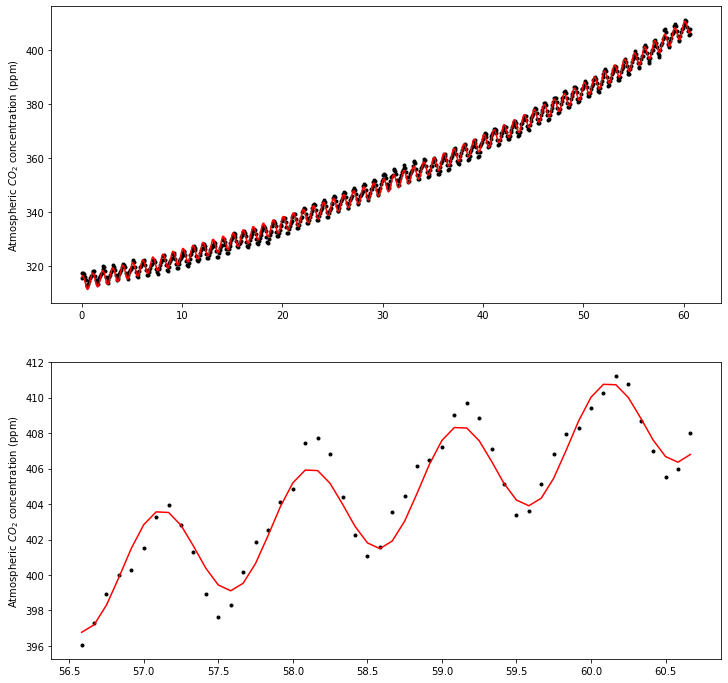

In [361]:
y_pred = exp_sin_model(x_obs, *par[0])

# Plot observations and predictions
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.plot(x_obs, y_obs, '.k')
plt.plot(x_obs, y_pred, '-r')
plt.ylabel('Atmospheric $CO_2$ concentration (ppm)')

plt.subplot(2,1,2)
subset = np.arange( df.shape[0]-50, df.shape[0])
plt.plot(x_obs[subset], y_obs[subset], '.k')
plt.plot(x_obs[subset], y_pred[subset], '-r')
plt.ylabel('Atmospheric $CO_2$ concentration (ppm)')

plt.show()

In [362]:
mae = maefn(y_obs, y_pred)
print('MAE is:',np.round(mae,2), 'ppm')


MAE is: 0.78 ppm


## Explore residuals

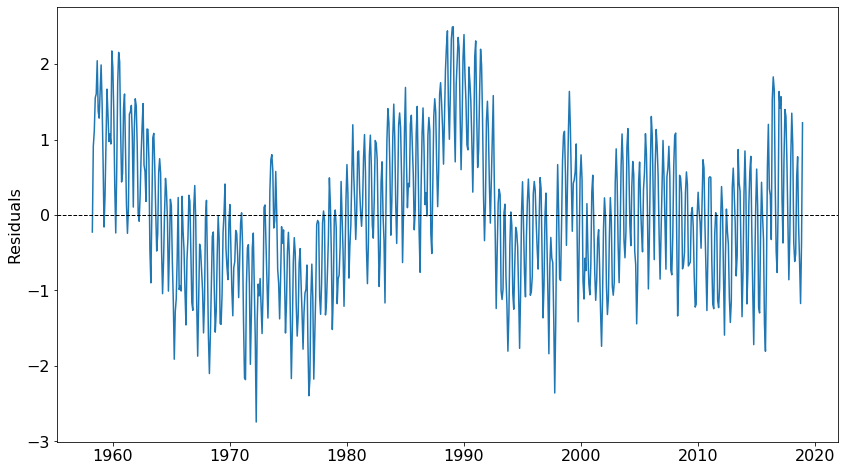

In [367]:
# Calculate residuals
residuals = y_obs - y_pred

# Plot
plt.figure(figsize=(14,8))
plt.plot(df['serial_date'], residuals)
plt.axhline(y=residuals.mean(), linewidth=1, color='k', linestyle='--')
plt.ylabel('Residuals', size=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()


In [290]:
co2_2050 = exp_sin_model(2050-df['serial_date'][0], *par[0])
print('Carbon dioxide concentration in 2050 is estimated to be:', np.round(co2_2050),'ppm')


Carbon dioxide concentration in 2050 is estimated to be: 508.0 ppm


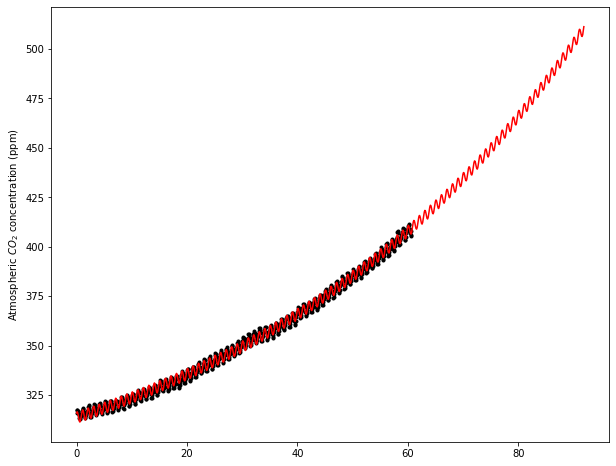

In [294]:
x_forecast = np.arange(df["year"][0],2050, 0.1) - df["year"][0]
y_forecast = exp_sin_model(x_forecast, *par[0])

plt.figure(figsize=(10,8))

plt.plot(x_obs, y_obs, '.k')
plt.plot(x_forecast, y_forecast, '-r')
plt.ylabel('Atmospheric $CO_2$ concentration (ppm)')

plt.show()


The model combining an exponential term and a sinusoidsl term can better simulate the seasonal and long-term dynamics of atmospheric carbon dioxide. From the point of view of forecasting the concentration the differen between the exponential-only and the sinusoidal-exponential modelis minimal and probably does not justify the extra complexity of the model.

## References

Data source: https://www.esrl.noaa.gov/gmd/ccgg/trends/full.html

NOAA Greenhouse Gas Marine Boundary Layer Reference: https://www.esrl.noaa.gov/gmd/ccgg/mbl/mbl.html

Mathworks documentation: https://www.mathworks.com/company/newsletters/articles/atmospheric-carbon-dioxide-modeling-and-the-curve-fitting-toolbox.html